# 0. Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import colorsys
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Reference Data

In [3]:
# Define the reference colors and values
reference_df = pd.read_csv('/content/drive/MyDrive/Projects/Research Projects/CO2_Sensor/Datasets/ph-data.csv')
# Create the dictionary
reference = {(r['red'], r['green'], r['blue']): r['label'] for _, r in reference_df.iterrows()}

# Convert RGB to HSL
reference_hsl = {}
for rgb, label in reference.items():
    r, g, b = rgb
    # Normalize RGB values to the [0, 1] range
    r /= 255.0
    g /= 255.0
    b /= 255.0
    # Convert to HSL
    h, s, l = colorsys.rgb_to_hls(r, g, b)
    # Store in the new dictionary
    reference_hsl[(h, s, l)] = label

# Prepare data
X = np.array(list(reference_hsl.keys()))
y = np.array(list(reference_hsl.values()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.1. Visualize Data: 14 Samples

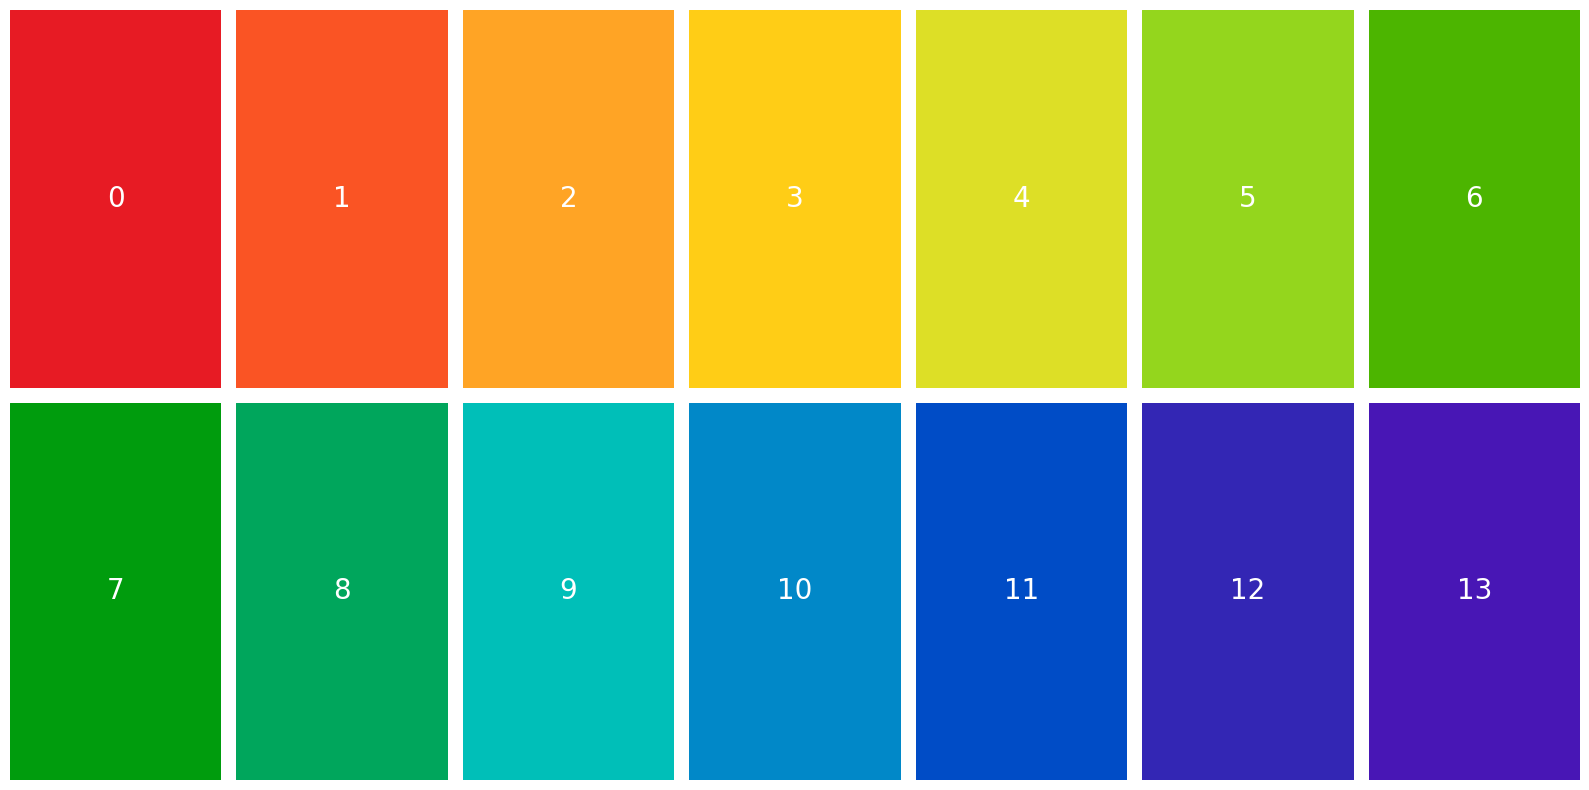

In [4]:
# Select the first 14 entries
reference_14 = dict(list(reference.items())[:14])

# Normalize RGB values to the range [0, 1]
normalized_reference_14 = {tuple(np.array(k) / 255): v for k, v in reference_14.items()}

# Create color tiles plot
n_colors = len(reference_14)
cols = 7
rows = n_colors // cols + (1 if n_colors % cols else 0)

fig, ax = plt.subplots(rows, cols, figsize=(16, 8))

for i, (color, ph) in enumerate(normalized_reference_14.items()):
    row, col = divmod(i, cols)
    ax[row, col].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    ax[row, col].text(0.5, 0.5, str(ph), fontsize=20, ha='center', va='center', color='w')
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

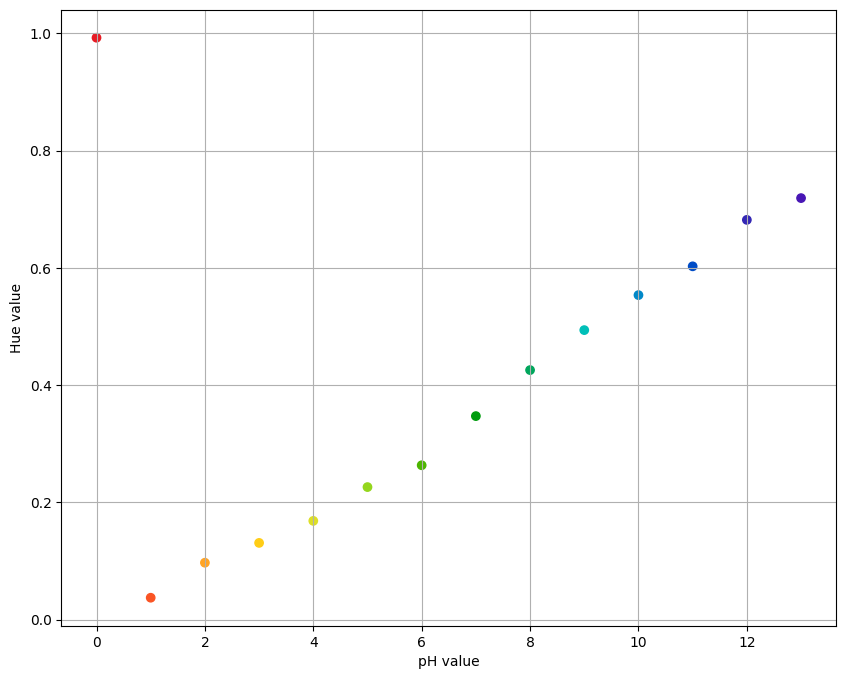

In [20]:
# Convert the RGB to HSL
hsl_reference_14 = {colorsys.rgb_to_hls(k[0], k[1], k[2]): v for k, v in reference_14.items()}
colors = [(k[0]/255, k[1]/255, k[2]/255) for k in reference_14.keys()]

# Prepare data for plot
hue_values = [hsl[0] for hsl in hsl_reference_14.keys()]
ph_values = list(hsl_reference_14.values())

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(ph_values, hue_values, color=colors)
#plt.title('Hue vs pH')
plt.xlabel('pH value')
plt.ylabel('Hue value')
plt.grid()
plt.show()

## 1.2. Visualize Data: Total Sample

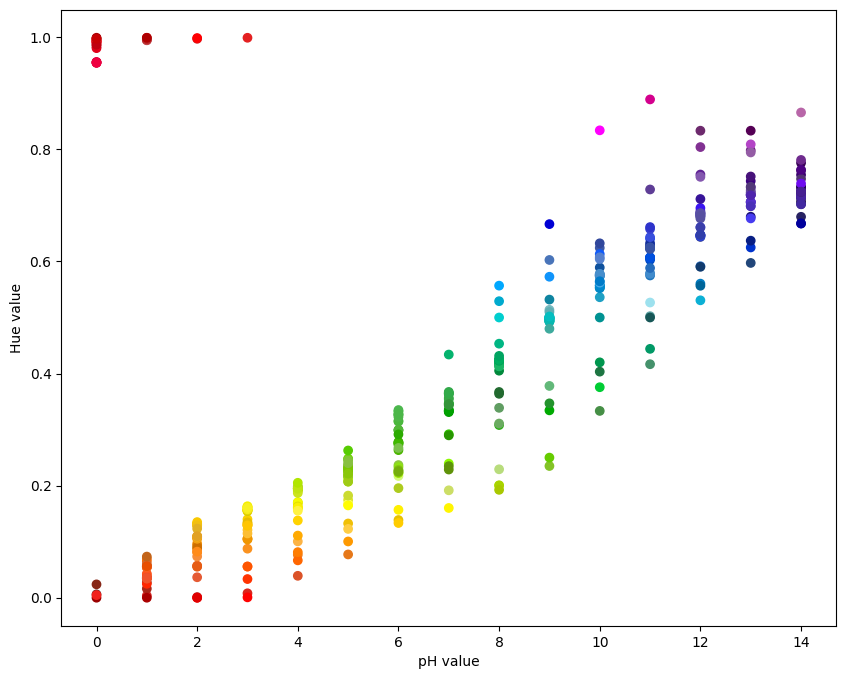

In [21]:
hue_reference = [colorsys.rgb_to_hls(k[0], k[1], k[2])[0] for k in reference.keys()]

# Prepare data for plot
hue_values = hue_reference
ph_values = list(reference.values())
colors = [(k[0]/255, k[1]/255, k[2]/255) for k in reference.keys()]

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(ph_values, hue_values, color=colors)
#plt.title('Hue vs pH')
plt.xlabel('pH value')
plt.ylabel('Hue value')

plt.show()

In [7]:
import plotly.graph_objects as go
import numpy as np

# Unpack the HSL and pH values
hsl_values, ph_values = zip(*reference_hsl.items())
hue_values, saturation_values, lightness_values = zip(*hsl_values)

# Convert hue_values to radians
hue_values = np.array(hue_values) * 2 * np.pi

# Convert cylindrical to cartesian coordinates
x = np.array(saturation_values) * np.cos(hue_values)
y = np.array(saturation_values) * np.sin(hue_values)
z = np.array(lightness_values)

# Create the plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=ph_values,            # set color to an array/list of desired values
        colorscale='Viridis',         # choose a colorscale
        opacity=0.8,
        colorbar=dict(title='pH value') # customize the colorbar
    )
)])

# Tight layout
fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Lightness'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# 2. Load Sample Image

In [8]:
IMAGE_PATH = '/content/drive/MyDrive/Projects/Research Projects/CO2_Sensor/Datasets/Images/Colors/'
IMAGE_FILE = '3_color_#4169E1.png'

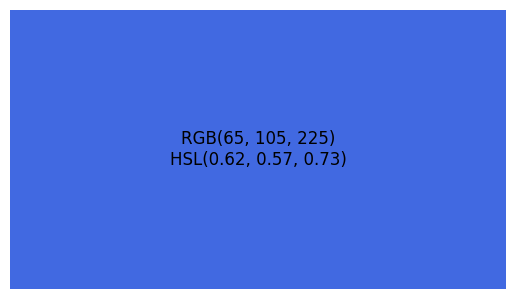

In [9]:
# Load image file
image = cv2.imread(os.path.join(IMAGE_PATH, IMAGE_FILE))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate the average RGB value using numpy.mean()
rgb_color_per_row = np.mean(image, axis=0)
rgb_color = np.mean(rgb_color_per_row, axis=0)
prompt_rgb = f"RGB({rgb_color[0]:.0f}, {rgb_color[1]:.0f}, {rgb_color[2]:.0f})"

# Normalize RGB values and convert to HSL
r, g, b = rgb_color / 255.0
hsl_color = colorsys.rgb_to_hls(r, g, b)
prompt_hsl = f"HSL({hsl_color[0]:.2f}, {hsl_color[1]:.2f}, {hsl_color[2]:.2f})"

# Choose white color for text if avg_color is dark, black if avg_color is light
text_color = 'white' if np.mean(rgb_color) < 128 else 'black'

fig, ax = plt.subplots()

# Show image
ax.imshow(image)

# Put RGB and HSL prompt text in the middle of the image
text_x = image.shape[1] / 2
text_y = image.shape[0] / 2

ax.text(text_x, text_y-40, prompt_rgb, fontsize=12, ha='center', va='center', color=text_color, bbox=dict(facecolor='none', edgecolor='none'))
ax.text(text_x, text_y+40, prompt_hsl, fontsize=12, ha='center', va='center', color=text_color, bbox=dict(facecolor='none', edgecolor='none'))

# Turn off axis
ax.axis('off')

plt.show()

# 3. Estimate Values

## 3.1. Polynomial Fit

In [10]:
# Select only the Hue data
X_hue = X[:, 0]

# Fit a polynomial of degree 3
coefficients = np.polyfit(X_hue, y, 3)

# Now we can use the coefficients to make predictions
predicted_ph = np.polyval(coefficients, hsl_color[0])

print(f"Predicted pH: {predicted_ph:.2f}")

Predicted pH: -0.27


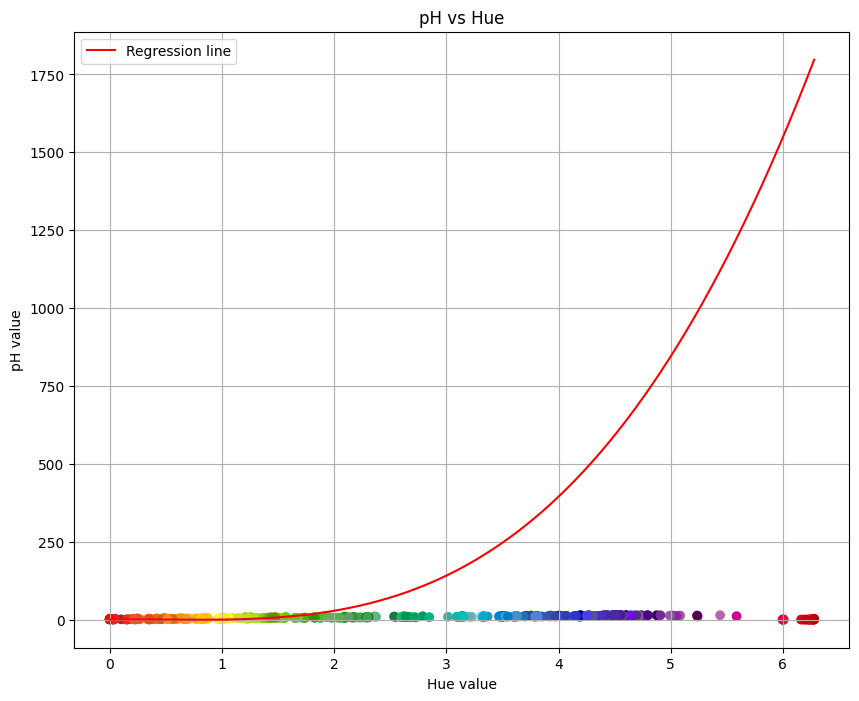

In [11]:
# Create a scatter plot of hue values vs. pH values
plt.figure(figsize=(10, 8))
plt.scatter(hue_values, ph_values, color=colors)  # Swap hue_values and ph_values

# Generate x and y values for the regression line
hue_values_line = np.linspace(min(hue_values), max(hue_values), 500)  # Swap ph_values with hue_values
ph_values_line = np.polyval(coefficients, hue_values_line)  # Swap hue_values_line with ph_values_line

# Plot the regression line
plt.plot(hue_values_line, ph_values_line, 'r', label='Regression line')  # Swap ph_values_line with hue_values_line

plt.title('pH vs Hue')  # Update title
plt.xlabel('Hue value')  # Update x label
plt.ylabel('pH value')  # Update y label
plt.legend()
plt.grid()
plt.show()

## 3.2. Random Forest Model

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the model on the test set
score = model_rf.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Now we can use the model to predict pH values
predicted_ph = model_rf.predict([hsl_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 94.71%
Predicted pH: 11.14


## 3.3. Gradient Boosting Model

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')

# Fit the model to the training data
model_gb.fit(X_train, y_train)

# Check the accuracy of the model on the testing data
score = model_gb.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Predict pH level for a given RGB value
predicted_ph = model_gb.predict([hsl_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 93.34%
Predicted pH: 11.05


## 3.4. Support Vector Machine

In [14]:
from sklearn.svm import SVR

# Initialize the model
model_svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Fit the model to the training data
model_svm.fit(X_train, y_train)

# Check the accuracy of the model on the testing data
score = model_svm.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Predict pH level for a given RGB value
predicted_ph = model_svm.predict([hsl_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 77.48%
Predicted pH: 10.49


## 3.5. Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=3, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1, activation='linear'))

# Compile the model
model_nn.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])

# Fit the model to the training data
model_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10, verbose=0)

# Evaluate the model
scores = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Model performance: MAE = {scores[1]:.2f}")

# Predict pH level for a given RGB value
predicted_ph = model_nn.predict(np.array(hsl_color).reshape(1, -1))

print(f"Predicted pH: {predicted_ph[0][0]:.2f}")

Model performance: MAE = 1.45
1/1 [==============================] - 0s 133ms/step
Predicted pH: 10.36


# 4. Results

1/1 [==============================] - 0s 25ms/step


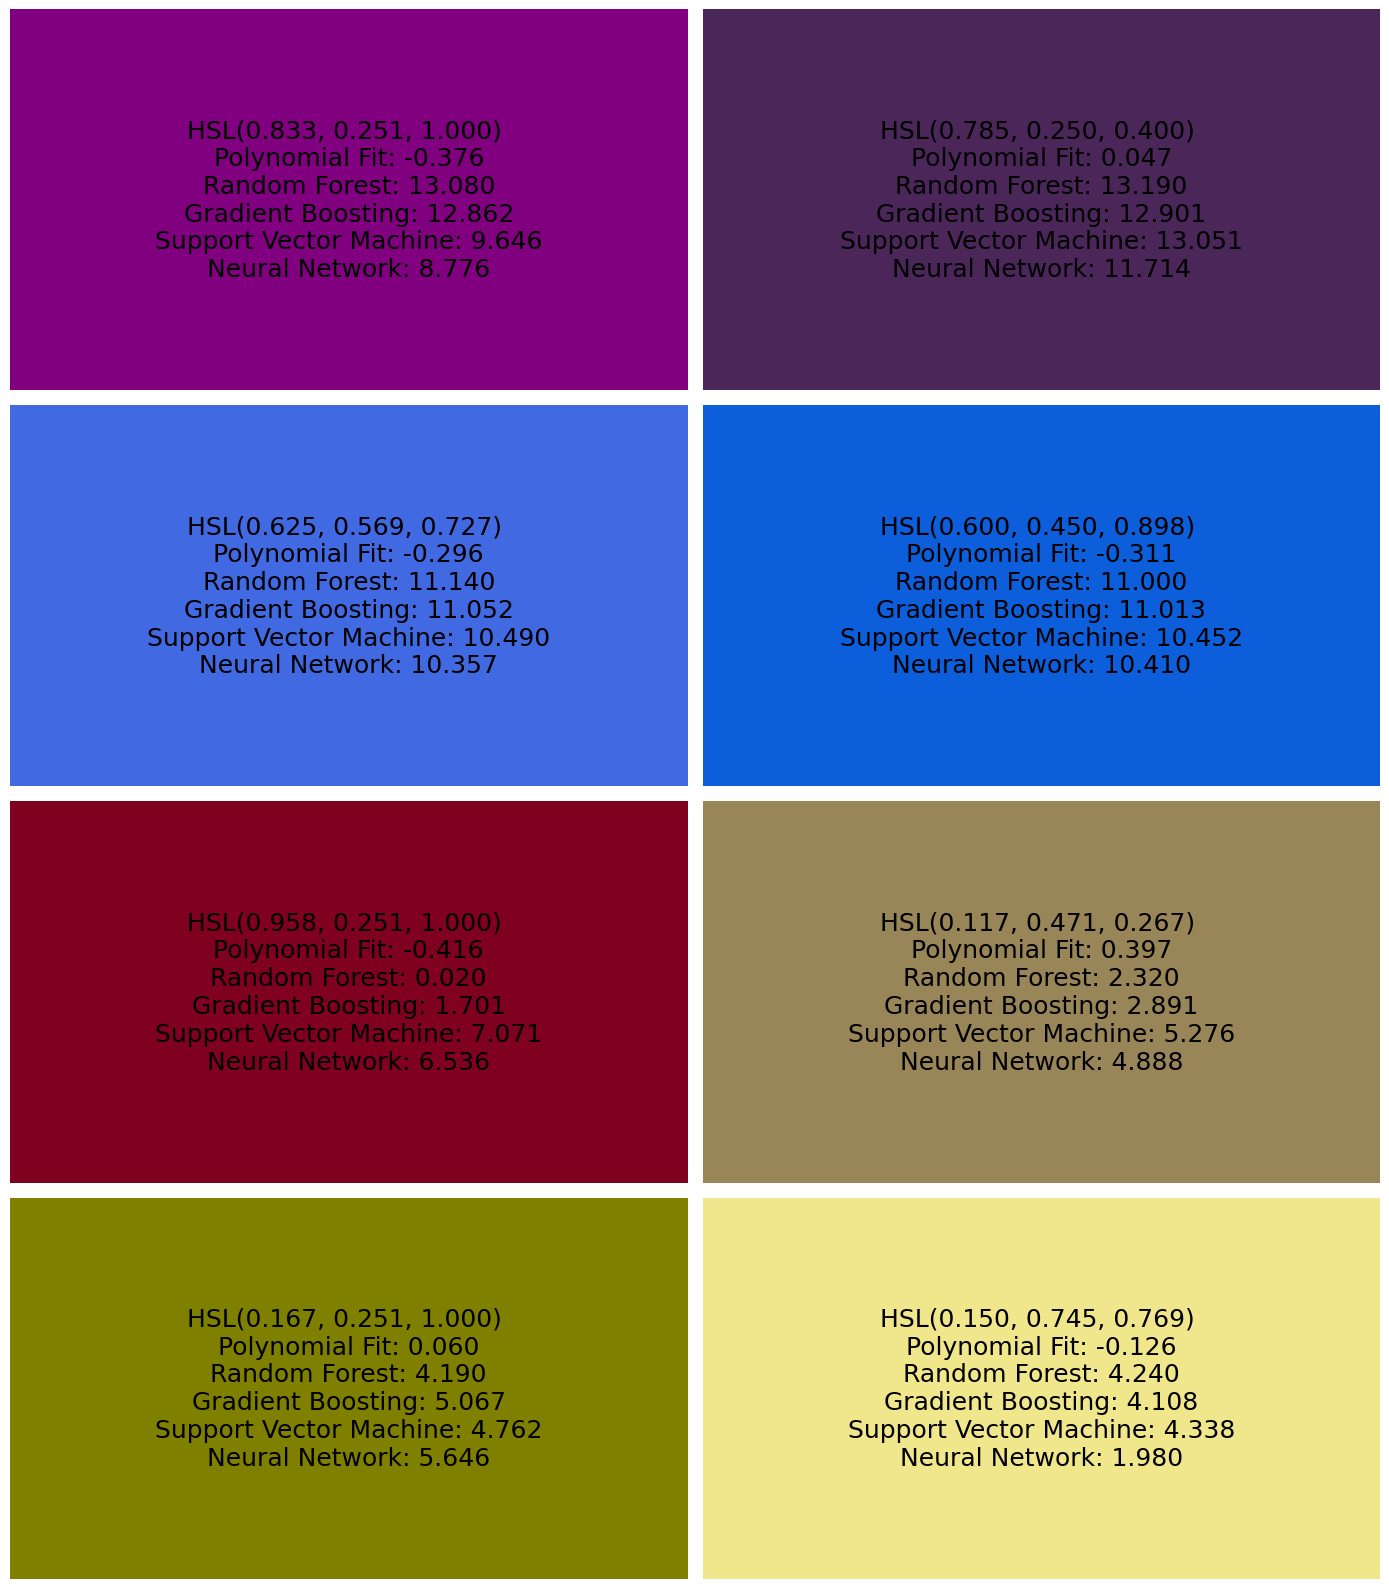

In [16]:
# Load images
FOLDER_PATH = '/content/drive/Shareddrives/CO2 sensor device/Min & Jamie/Datasets/Images/Colors/'
image_files = os.listdir(FOLDER_PATH)

# Define the number of columns for the plot
cols = 2

# Define the number of rows needed for the plot
rows = len(image_files) // cols
if len(image_files) % cols:
    rows += 1

# Initialize the plot
fig, ax = plt.subplots(rows, cols, figsize=(14, 16))

# Initialize the list to store average colors of test images
avg_colors = []

# Iterate over the images
for i, image_file in enumerate(image_files):
    # Load image file
    image = cv2.imread(os.path.join(FOLDER_PATH, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the average RGB value using numpy.mean()
    avg_color_per_row = np.mean(image, axis=0)
    avg_color = np.mean(avg_color_per_row, axis=0)
    
    # Normalize RGB values and convert to HSL
    r, g, b = avg_color / 255.0
    avg_color_hsl = colorsys.rgb_to_hls(r, g, b)
    avg_colors.append(avg_color_hsl)

    # Predict
    # Random Forest Model
    ph_rf = model_rf.predict([avg_color_hsl])

    # Polynomial Fit
    hsl_value_flat = np.mean(avg_color_hsl)
    ph_pf = np.polyval(coefficients, hsl_value_flat)

    # Gradient Boosting Model
    ph_gb = model_gb.predict([avg_color_hsl])

    # Support Vector Machine
    ph_svm = model_svm.predict([avg_color_hsl])

    # Neural Network
    ph_nn = model_nn.predict(np.array(avg_color_hsl).reshape(1, -1))

    # Compute current row and column
    row, col = divmod(i, cols)

    # Convert HSL back to RGB for color tile
    rgb_color = colorsys.hls_to_rgb(*avg_color_hsl)

    # Create color tile
    ax[row, col].add_patch(plt.Rectangle((0, 0), 1, 1, color=rgb_color))
    ax[row, col].axis('off')

    # Add text to the tile
    results = results = (
    f"HSL({avg_color_hsl[0]:.3f}, {avg_color_hsl[1]:.3f}, {avg_color_hsl[2]:.3f}) \n"
    f"Polynomial Fit: {ph_pf:.3f}\n"
    f"Random Forest: {ph_rf[0]:.3f}\n"
    f"Gradient Boosting: {ph_gb[0]:.3f}\n"
    f"Support Vector Machine: {ph_svm[0]:.3f}\n"
    f"Neural Network: {ph_nn[0][0]:.3f}"
    )
    ax[row, col].text(0.5, 0.5, results, fontsize=18, ha='center', va='center', color='k')

# For any leftover subplots, remove their axes
for j in range(i+1, rows*cols):
    row, col = divmod(j, cols)
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()